# Project Notebook IV: Supervised Learning with Sagemaker XGBoost with Hyperparameter Tuning

David Chen

In [1]:
!pip install sagemaker==1.72.0

In [2]:
import pandas as pd 
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline

import sagemaker
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker.predictor import csv_serializer
import boto3

## My custom helper functions
from helpers import *

## Step 1. Sagemaker Resources & Processed+FeatureSelected Data Saved in S3

In [3]:
sagemaker_session = sagemaker.Session()
sagemaker_session

In [4]:
role = sagemaker.get_execution_role()
role

'arn:aws:iam::644307290749:role/service-role/AmazonSageMaker-ExecutionRole-20210527T073969'

In [5]:
bucket = sagemaker_session.default_bucket()
bucket

'sagemaker-us-west-1-644307290749'

In [6]:
## Load processed features:
genes = pd.read_csv(get_s3_uri("assets/processed_data/genes_l1_selected.csv", bucket), index_col=0)
genes.shape

(999, 33)

In [7]:
## Load processed patient annotations (with defined class label):
clinical = pd.read_csv(get_s3_uri("assets/processed_data/clinical.csv", bucket))
clinical.shape

(999, 15)

In [8]:
clinical.index = clinical['Sample ID'].values

In [9]:
## Check to see if patient IDs in the 2 DataFrames match
all(genes.index == clinical.index)

True

## Step 2. Train-val-test split & save for Sagemaker XGBoost

### Perform Train-val-test split

In [10]:
from sklearn.model_selection import train_test_split

SIZE_VAL_TEST = 100 #set aside 100 observations for validation & testing

## Run sklearn helper 1st time to split out the test set:
## The hold-out test set is NEVER used until the very end
Xtrain, Xtest, ytrain, ytest = train_test_split(
    genes, 
    clinical["Label"].astype(int), 
    test_size=SIZE_VAL_TEST, 
    random_state=42
)

In [11]:
## Run sklearn helper again to split out a validation set for optimization
Xtrain, Xval, ytrain, yval = train_test_split(Xtrain, ytrain.astype(int), test_size=SIZE_VAL_TEST)

### Concatenate class label (y) & features (X) for each set and directly export to S3 bucket

Concatenation is required ONLY for training and validation set but NOT for the test set.

In [12]:
directS3Save(pd.concat([ytrain, Xtrain], axis=1), bucket, "assets/tnbc-xgboost/train.csv", False, False)

In [13]:
directS3Save(pd.concat([yval, Xval], axis=1), bucket, "assets/tnbc-xgboost/validation.csv", False, False)

In [14]:
## For Test set, do NOT concatenate
directS3Save(Xtest, bucket, "assets/tnbc-xgboost/test.csv", False, False)

## Step 3. Train Sagemaker XGBoost

In [15]:
container = get_image_uri(sagemaker_session.boto_region_name, 'xgboost')
container

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
There is a more up to date SageMaker XGBoost image. To use the newer image, please set 'repo_version'='1.0-1'. For example:
	get_image_uri(region, 'xgboost', '1.0-1').


'632365934929.dkr.ecr.us-west-1.amazonaws.com/xgboost:1'

In [16]:
prefix = "tnbc-xgboost"

In [17]:
xgb = sagemaker.estimator.Estimator(
    container, 
    role,
    train_instance_count = 1,
    train_instance_type = 'ml.m4.xlarge',
    output_path = 's3://{}/{}/output'.format(bucket, prefix),
    sagemaker_session = sagemaker_session
)

Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.


In [18]:
xgb.set_hyperparameters(
    max_depth = 5,
    eta = 0.2,
    gamma = 4,
    min_child_weight = 6,
    subsample = 0.8,
    objective = 'binary:logistic',
    early_stopping_rounds = 10,
    num_round = 100
)

In [19]:
s3_input_train = sagemaker.s3_input(
    s3_data = get_s3_uri(os.path.join("assets",prefix,"train.csv"), bucket), 
    content_type = 'csv'
)

s3_input_train

's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


In [20]:
s3_input_val = sagemaker.s3_input(
    s3_data = get_s3_uri(os.path.join("assets",prefix,"validation.csv"), bucket), 
    content_type = 'csv'
)

s3_input_val

's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


In [21]:
xgb.fit({'train': s3_input_train, 'validation': s3_input_val})

2021-05-28 03:22:02 Starting - Starting the training job...
2021-05-28 03:22:04 Starting - Launching requested ML instances......
2021-05-28 03:23:11 Starting - Preparing the instances for training......
2021-05-28 03:24:25 Downloading - Downloading input data...
2021-05-28 03:25:00 Training - Training image download completed. Training in progress..Arguments: train
[2021-05-28:03:25:01:INFO] Running standalone xgboost training.
[2021-05-28:03:25:01:INFO] File size need to be processed in the node: 0.23mb. Available memory size in the node: 8422.4mb
[2021-05-28:03:25:01:INFO] Determined delimiter of CSV input is ','
[03:25:01] S3DistributionType set as FullyReplicated
[03:25:01] 799x33 matrix with 26367 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2021-05-28:03:25:01:INFO] Determined delimiter of CSV input is ','
[03:25:01] S3DistributionType set as FullyReplicated
[03:25:01] 100x33 matrix with 3300 entries loaded from /opt/ml/input/data/validatio

## Step 4. Evaluate the Trained Model

### Apply trained model to the hold-out test set

In [22]:
xgb_transformer = xgb.transformer(instance_count=1, instance_type='ml.m4.xlarge')

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


In [23]:
## The syntax for inference is unique from training-validation:
xgb_transformer.transform(
    get_s3_uri(os.path.join("assets",prefix,"test.csv"), bucket),
    content_type = 'text/csv', 
    split_type = 'Line'
)

In [24]:
xgb_transformer.wait()

...........................
Arguments: serve
[2021-05-28 03:32:57 +0000] [1] [INFO] Starting gunicorn 19.9.0
[2021-05-28 03:32:57 +0000] [1] [INFO] Listening at: http://0.0.0.0:8080 (1)
[2021-05-28 03:32:57 +0000] [1] [INFO] Using worker: gevent
[2021-05-28 03:32:57 +0000] [21] [INFO] Booting worker with pid: 21
[2021-05-28 03:32:57 +0000] [22] [INFO] Booting worker with pid: 22
/opt/amazon/lib/python3.7/site-packages/gunicorn/workers/ggevent.py:65: MonkeyPatchWarning: Monkey-patching ssl after ssl has already been imported may lead to errors, including RecursionError on Python 3.6. It may also silently lead to incorrect behaviour on Python 3.7. Please monkey-patch earlier. See https://github.com/gevent/gevent/issues/1016. Modules that had direct imports (NOT patched): ['urllib3.util (/opt/amazon/lib/python3.7/site-packages/urllib3/util/__init__.py)', 'urllib3.util.ssl_ (/opt/amazon/lib/python3.7/site-packages/urllib3/util/ssl_.py)']. 
  monkey.patch_all(subprocess=True)
[2021-05-28:03

In [25]:
## Magick-copy XGBoost inference output to specified directory accessible by Notebook
data_dir = './'

In [26]:
!aws s3 cp --recursive $xgb_transformer.output_path $data_dir

download: s3://sagemaker-us-west-1-644307290749/xgboost-2021-05-28-03-28-13-140/test.csv.out to ./test.csv.out


### Evaluation on hold-out test set

In [27]:
yTestScore = pd.read_csv(os.path.join(data_dir, 'test.csv.out'), header=None)

In [28]:
yTestPred = (yTestScore > 0.5).astype(int)

In [30]:
from sklearn import metrics
print(metrics.classification_report(ytest, yTestPred))

              precision    recall  f1-score   support

           0       0.98      0.93      0.95        89
           1       0.60      0.82      0.69        11

    accuracy                           0.92       100
   macro avg       0.79      0.88      0.82       100
weighted avg       0.94      0.92      0.93       100



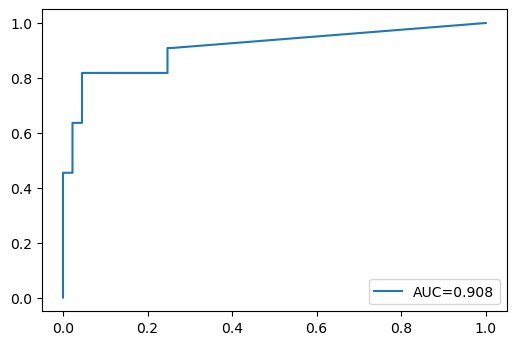

In [32]:
plot_roc(ytest, yTestScore)